# Extracting docking scores from AutoDockGPU (DLG) files

## Author: [Riccardo Fusco](https://github.com/HiteSit/AutoDock_GPU_Scripts)<img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" alt="github" width="25"/>  
Each *.dlg* file generated by AutoDockGPU contains the following data:

1) the number of runs/poses
2) the information on scoring
3) the pdbqt coordinate. 

- This script will take as input a working directory containing all of the *.dlg* files generated by a virtual screening

- The script will read the RMSD table at the end of each ligand output file and save the best cluster poses in *.sdf* format.

The conformational energy of each pose (run) will be calculated using an Autodock-independent tool called rdkit. Then, based on the smiles, it will conduct a conformational stocastic search to find the global minimum (rdkit). The delta conformational energy (pose conformational energy minus global minimum conformational energy) will be calculated from the two measurements.

Everything will be compiled into a nice Excel table for further examination.

The script also works for flexible docking.

In [3]:
# Importing necessary libraries
import glob
import os
import shutil
import re
import math
import pdb

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# For working with chemical compounds
from openbabel import pybel, openbabel
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, rdFMCS

# Suppressing warnings
import warnings
warnings.filterwarnings(action='ignore')
pybel.ob.obErrorLog.SetOutputLevel(0)

In [4]:
def calc_energy(pdbqt_string, reference)-> int:

    m = pybel.readstring("pdbqt", pdbqt_string)
    m.addh()
    m.convertdbonds()
    mol_h = Chem.MolFromMol2Block(m.write('mol2'),sanitize=True,removeHs=False)
    
    if reference == True:
        AllChem.Compute2DCoords(mol_h,clearConfs=True,canonOrient=True)
        AllChem.EmbedMolecule(mol_h,params=AllChem.ETKDGv2())

    ff_ref = AllChem.MMFFGetMoleculeForceField(mol_h,AllChem.MMFFGetMoleculeProperties(mol_h))
    ff_ref.Initialize()
    
    if reference == True:
        ff_ref.Minimize(maxIts=1000)

    ref_energy = round(ff_ref.CalcEnergy(),2)

    return ref_energy, mol_h

In [5]:
def write_table(file:str):
    basename = file.split(".")[0]

    #### Some preliminary operations
    # Grab the file
    # Divide the files in block
    # Clean the blocks from DOCKED:
    # It's necessary to create two different blocks, one with the flexible residues and another one without.
    # This because when rdkit analyze the molecule the residue have to be obmitted, differently when the molecule is written the residues have to be there.
    with open(file, 'r') as f:
        doc = f.read()
        clean = doc.replace("DOCKED: ", "")

        blocks = re.findall("(\\nRun.*?ENDMDL\\n)",clean,re.DOTALL)

        blocks_temp = re.findall("(\\nRun.*?TORSDOF \d)",clean,re.DOTALL)
        blocks_nores = [x + "\nTER\nENDMDL\n" for x in blocks_temp]

    #### Calculate the global minimum conformational energy
    ref_energy = calc_energy(blocks_nores[10],True)[0]

    # Runs number
    runs = [x for x in range(len(blocks))]

    zipped = list(zip(runs,blocks,blocks_nores))

    data = []
    for num, res, nores in zipped:
        energy_pose, mol = calc_energy(nores, False)
        data.append((basename, num+1, mol, res, energy_pose, ref_energy, energy_pose-ref_energy))

    df_all = pd.DataFrame(data, columns=['Name', 'Run', 'Mol', 'Pdbqt_str', 'Conf_Energy', 'Ref_Conf_Energy', 'Delta_conf_Energy'])

    #### Calculate the conformation only of the clusterized poses
    # Grab the best clusters number
    best_clusters_num = [int(x.group(1)) for x in re.finditer(r'[^\d][\s\d][\s\d]\s\W\s\s\s\s[\s\W][\s\d\W]\d\W\d\d\s\W\s([\d\s]+)\W\s\s\s\s[\s\W]',doc)]

    data = []
    for num in best_clusters_num:
        energy_pose, mol = calc_energy(blocks_nores[num-1], False)
        data.append((basename, num, mol, blocks[num-1], energy_pose, ref_energy, energy_pose-ref_energy))

    df_best = pd.DataFrame(data, columns=['Name', 'Run', 'Mol', 'Pdbqt_str', 'Conf_Energy', 'Ref_Conf_Energy', 'Delta_conf_Energy'])

    def make_full(dataframe, type):
        best_list = dataframe["Pdbqt_str"].values.tolist()

        pattern = r'([\w\s]*)=\s*([+-]?\d+\.\d+)'

        all_matches = [re.findall(pattern, pose) for pose in best_list]
        all_matches = [[match[1] for match in matches] for matches in all_matches]

        scoretable = pd.DataFrame(
        np.vstack(all_matches),
        columns=[
            "Binding Energy",
            "Intermolecular Energy",
            "VdW + Hbond + desolv Energy",
            "Electrostatic Energy",
            "Moving Ligand-Fixed Receptor",
            "Moving Ligand-Moving Receptor",
            "Final Total Internal Energy",
            "Torsional Free Energy",
            "Unbound System's Energy"
            ]
        )
        
        if type == "all":
            final_df = pd.concat([df_all,scoretable],axis=1)
        
        if type == "best":
            final_df = pd.concat([df_best,scoretable],axis=1)

        return final_df

    #### Complete the table with the scores data
    df_best_complete = make_full(df_best, "best")
    df_all_complete = make_full(df_all, "all")


    return df_best_complete, df_all_complete

In [6]:
# Concatenate (vertically) all the table from the virtual screeening
files = glob.glob("*.dlg")

# Create empty dataframes to store the full and best tables
df_full = pd.DataFrame()
df_best = pd.DataFrame()

# Iterate through all files in the current directory
for file in files:

    # Get the best and complete tables for each file
    try:
        best, complete = write_table(file)
    except:
        print(f"elaboration {file} failed")
        continue

    # Concatenate the full and best tables
    df_full = pd.concat([df_full, complete], ignore_index=True)
    df_best = pd.concat([df_best, best], ignore_index=True)

    # Get the Pdbqt_str, Name, and Run values from the best table
    pdbqt_values = best["Pdbqt_str"].values.tolist()
    name_value = best["Name"].values.tolist()[0]
    run_values = best["Run"].values.tolist()
    
    # Create a tuple of Pdbqt_str and Run values
    mytup = list(zip(pdbqt_values, run_values))

    # Compile the regular expression pattern
    pattern = re.compile("END_RES[\w\s].+|BEGIN_RES[\w\s].+")

    # Create an empty list to store the mol2 strings
    full_string = []

    # Iterate through the tuple of Pdbqt_str and Run values
    for pdbqt, run in mytup:
        one = pattern.sub("", pdbqt)
        mol = pybel.readstring("pdbqt", one)
        mol.title = str(run)
        full_string.append(mol.write("mol2"))
        
    # Open the output file and write the mol2 strings
    with open(name_value + ".mol2", "w") as f:
        f.write("".join(full_string))

RDKit WARNING: [17:03:27] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:03:27] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:27] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:27] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:27] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:27] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:03:27] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:03:27] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:03:27] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:03:27] =: Warning - n

In [7]:
df_best.head()

,Name,Run,Mol,Pdbqt_str,Conf_Energy,Ref_Conf_Energy,Delta_conf_Energy,Binding Energy,Intermolecular Energy,VdW + Hbond + desolv Energy,Electrostatic Energy,Moving Ligand-Fixed Receptor,Moving Ligand-Moving Receptor,Final Total Internal Energy,Torsional Free Energy,Unbound System's Energy
0,12a,50,"<img data-content=""rdkit/molecule"" src=""data:i...",\nRun: 50 / 100\nTime taken for this run: ...,263.63,125.2,138.43,-16.42,-18.51,-8.71,-0.13,-8.84,-9.67,-3.44,+2.09,-3.44
1,12a,90,"<img data-content=""rdkit/molecule"" src=""data:i...",\nRun: 90 / 100\nTime taken for this run: ...,273.96,125.2,148.76,-15.63,-17.71,-7.93,-0.13,-8.06,-9.65,-3.93,+2.09,-3.93
2,12a,65,"<img data-content=""rdkit/molecule"" src=""data:i...",\nRun: 65 / 100\nTime taken for this run: ...,264.73,125.2,139.53,-15.20,-17.28,-7.16,+0.15,-7.01,-10.27,-3.18,+2.09,-3.18
3,12a,80,"<img data-content=""rdkit/molecule"" src=""data:i...",\nRun: 80 / 100\nTime taken for this run: ...,270.50,125.2,145.30,-14.81,-16.90,-7.11,-0.10,-7.21,-9.68,-4.28,+2.09,-4.28
4,12a,60,"<img data-content=""rdkit/molecule"" src=""data:i...",\nRun: 60 / 100\nTime taken for this run: ...,275.62,125.2,150.42,-14.41,-16.50,-7.39,-0.07,-7.46,-9.04,-4.62,+2.09,-4.62


#### Calculate RMSD and Param Map

In [8]:
dlg_files = glob.glob("*.dlg")

In [9]:
param_directory = "param_map"
if not os.path.exists(param_directory):
    os.makedirs(param_directory)

In [10]:
RMSD_directory = "RMSD_map"
if not os.path.exists(RMSD_directory):
    os.makedirs(RMSD_directory)

In [11]:
def param_map(myfile):
    plt.rcParams['axes.linewidth'] = 1.5

    # Creating a jointplot using seaborn
    ax = sns.jointplot(data=write_table(myfile)[1], x='Intermolecular Energy', y='Delta_conf_Energy',
                    height=6, ratio=4, marginal_ticks=True, s=25, color='lightgreen',
                    edgecolor="k", linewidth=0.1, alpha=0.8, marginal_kws=dict(bins=30, fill=True))

    # Setting x and y-axis labels
    plt.xlabel('Binding Energy', fontsize=16, fontweight='bold')
    plt.ylabel('delta_energy', fontsize=16, fontweight='bold')

    # Setting tick parameters
    plt.tick_params('both', width=2, labelsize=12)

    # Removing top and right spines of the plot
    ax.ax_joint.spines['top'].set_visible(False)
    ax.ax_joint.spines['right'].set_visible(False)

    return ax

RDKit WARNING: [17:03:30] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:03:30] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:30] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:30] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:30] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:30] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:03:30] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:03:30] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:03:30] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:03:30] =: Warning - n

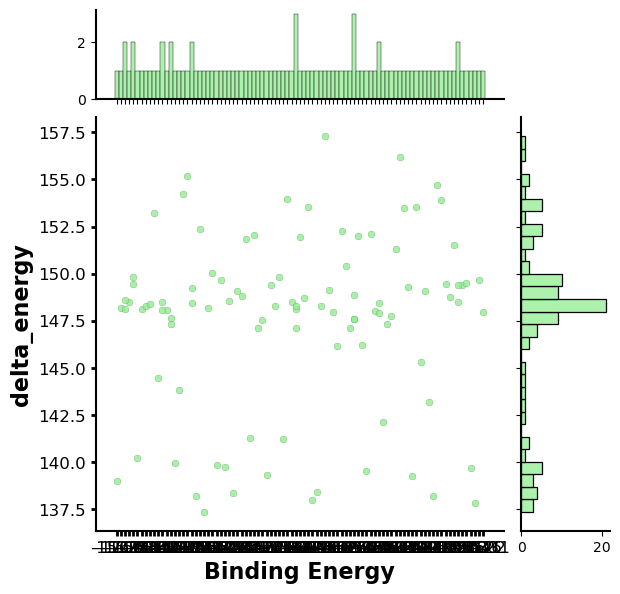

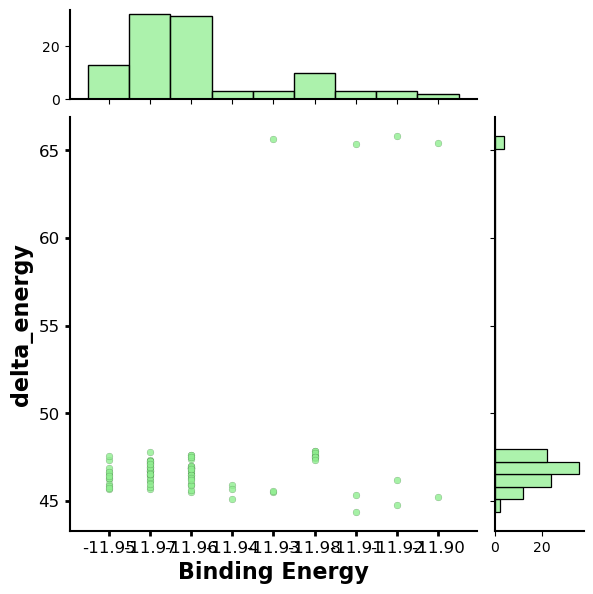

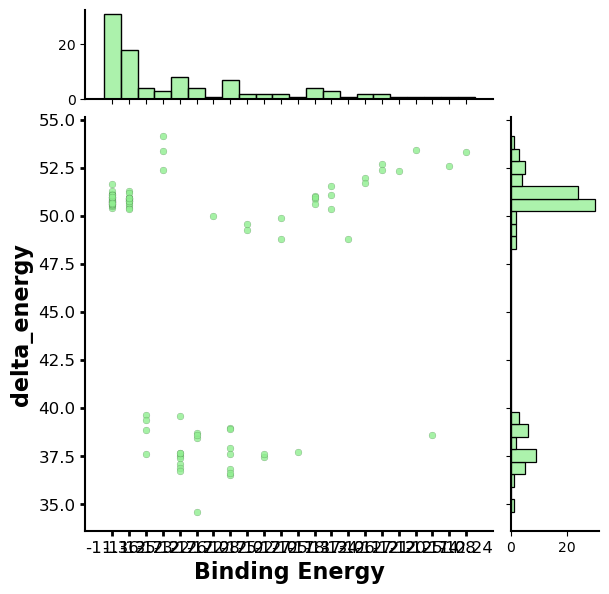

In [12]:
for file in dlg_files:

    # Save Chart
    param_chart = param_map(file)
    param_chart.savefig(file.split(".")[0] + "_param_map.jpg", dpi=300, format="jpeg")

    image_file = file.split(".")[0] + "_param_map.jpg"
    shutil.move(image_file, f"{param_directory}/")

In [13]:
def calculate_rmsd(energytable: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates RMSD between all poses in the energytable, return a matrix of RMSD values
    energytable: DataFrame with columns 'Pose_Mol' and 'Pose_num'
    """
    hmap = pd.DataFrame()
    for index in energytable.index:
        for jndex in energytable.index:
            reference = energytable.Mol[index]
            target = ref=energytable.Mol[jndex]

            r = rdFMCS.FindMCS([reference, target])             
            a = reference.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))
            b = target.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))
            amap = list(zip(a, b))

            distances = []
            for atomA, atomB in amap:
                pos_A = reference.GetConformer().GetAtomPosition (atomA)
                pos_B = target.GetConformer().GetAtomPosition (atomB)
                coord_A = np.array((pos_A.x, pos_A.y, pos_A.z))
                coord_B = np.array ((pos_B.x, pos_B.y, pos_B.z))
                dist_numpy = np.linalg.norm(coord_A - coord_B)        
                distances.append(dist_numpy)

            # This is the RMSD formula from wikipedia
            rmsd = math.sqrt(1/len(distances)*sum([i*i for i in distances])) 

            #saving the rmsd values to a matrix and a table for clustering
            hmap.loc[energytable.Run[index], energytable.Run[jndex]] = rmsd
    
    return hmap

In [14]:
def heatmap_plot(hmap: pd.DataFrame) -> None:
    """
    Plot a heatmap of the dataframe hmap.

    Parameters
    ----------
    hmap : pd.DataFrame
        The dataframe containing the data to be plotted.
    """
    # Create the heatmap
    ax = sns.clustermap(hmap,
                       xticklabels=hmap.index.astype(int),
                       yticklabels=hmap.index.astype(int),
                       cmap='RdBu_r',
                       method='complete',
                       center=0.5,
                       tree_kws=dict(linewidths=1.5),
                       figsize=(8, 8))

    # Adjust the colorbar
    x0, _y0, _w, _h = ax.cbar_pos
    ax.ax_cbar.set_position([x0+0.05, 0.82, _w/2, _h/1.3])
    ax.ax_cbar.set_ylabel('RMSD (Å)', fontsize=10, fontweight='bold')
    ax.ax_cbar.tick_params(axis='y', length=3, width=1, labelsize=10)

    # Adjust the x and y labels
    ax.ax_heatmap.set_ylabel('Pose Num', fontsize=22, fontweight='bold', rotation=90)
    ax.ax_heatmap.set_xlabel('Pose Num', fontsize=22, fontweight='bold', rotation=0)

    # Adjust the tick parameters
    ax.ax_heatmap.tick_params(axis='both', length=2, width=1, labelsize=5)

    return ax

RDKit WARNING: [17:03:33] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:03:33] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:34] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:34] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:34] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[17:03:34] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:34] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:34] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit WARNING: [17:03:34] =: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimat

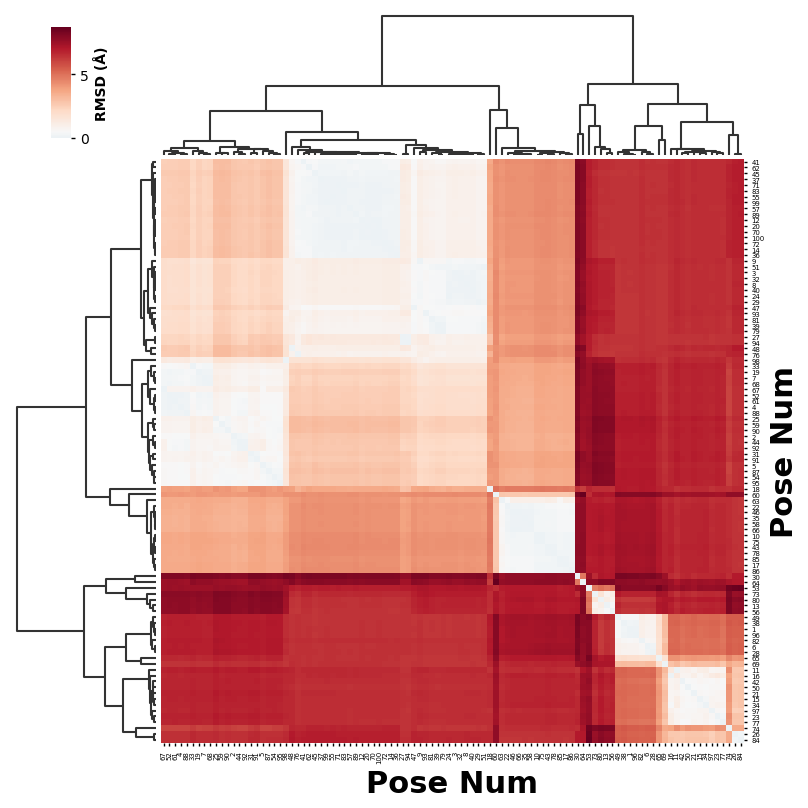

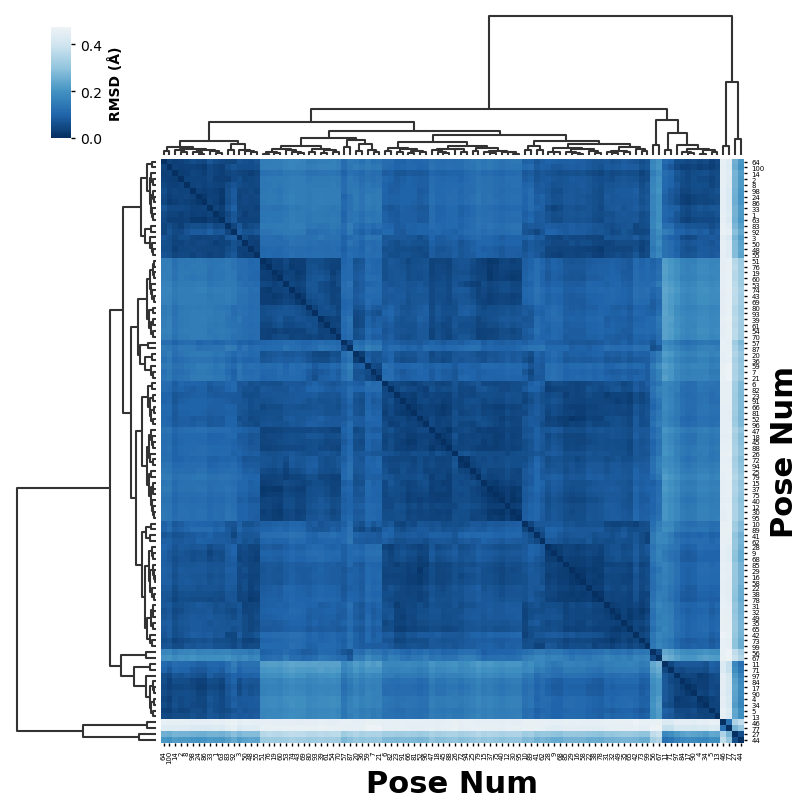

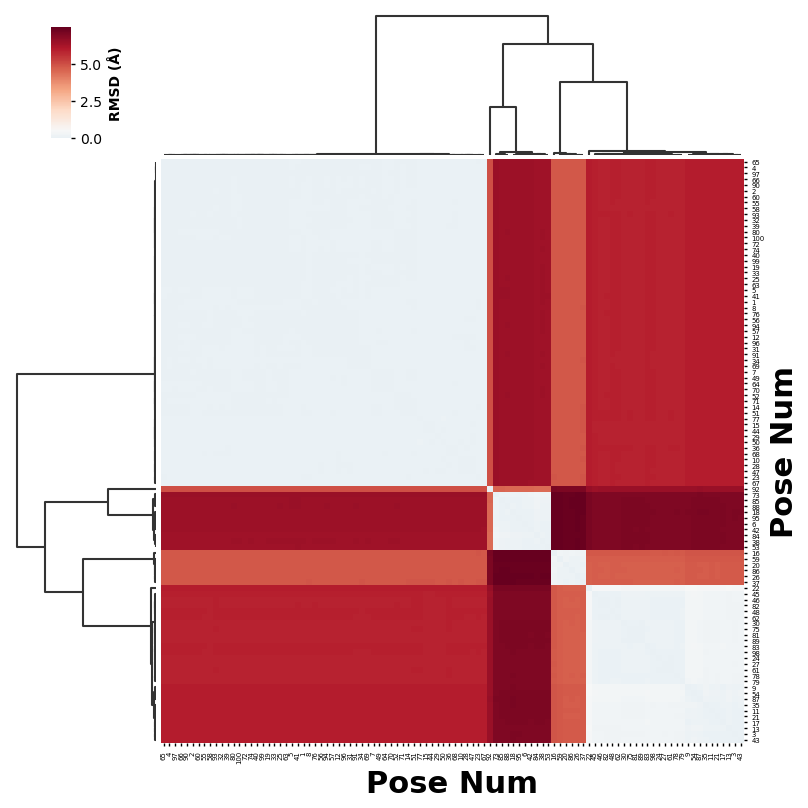

In [15]:
for file in dlg_files:
    
    # Write RMSD charts
    hmap = calculate_rmsd(write_table(file)[1])
    hmap_fig = heatmap_plot(hmap)
    hmap_fig.savefig(file.split(".")[0] + "_RMSD_map.jpg", dpi=300, format="jpeg")

    # Move RMSD charts
    image_file = file.split(".")[0] + "_RMSD_map.jpg"
    shutil.move(image_file, f"{RMSD_directory}/")